In [16]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys
import random

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [42]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    epsilon-greedy policy: select an action that has maximum Q-function value with probability epsilon,
                            or select arbitrary action with probability 1-epsilon
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        pass
        # Implement this!
        action_value_list = Q[observation]
        optimal_action = np.argmax(action_value_list)
        action_prob_list = np.ones(nA)*(epsilon)/(nA-1)
        action_prob_list[optimal_action] = 1-epsilon

        return action_prob_list


    return policy_fn

In [43]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    # Implement this!
    for i in range(num_episodes):

        # 1. episode 생성 및 저장
        episode_list = []
        state = env.reset()
        t = 0
        while True:
            # select action from policy
            action = np.random.choice(np.arange(env.action_space.n), p=policy(state))
            next_state, reward, done, _ = env.step(action)
            episode_list.append((state, action, reward))
            t+=1

            if done or t==100:
                break
            state = next_state
        
        # 2. 생성한 episode를 통해 Q value update 및 policy update
        G = 0
        for step in range(len(episode_list)-1,-1,-1):
            G = discount_factor * G + episode_list[step][2]
            returns_sum[episode_list[step][0]] += G
            returns_count[episode_list[step][0]] += 1
            Q[episode_list[step][0]][episode_list[step][1]] = returns_sum[episode_list[step][0]] / returns_count[episode_list[step][0]]

            policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)


    return Q, policy

In [44]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

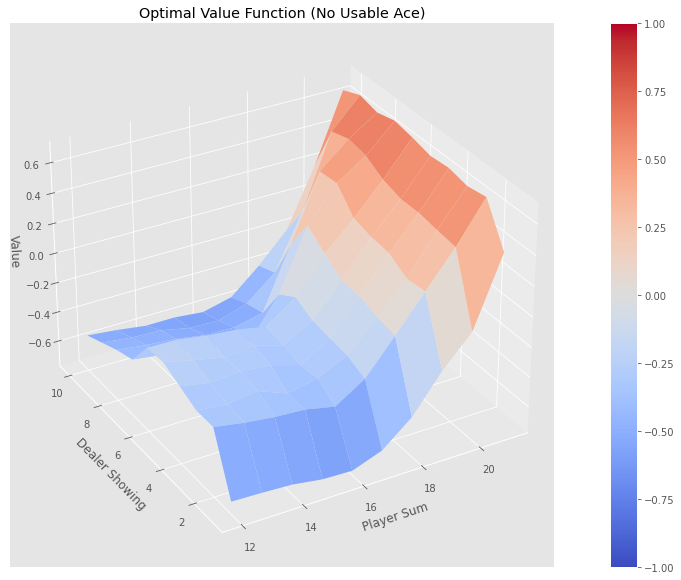

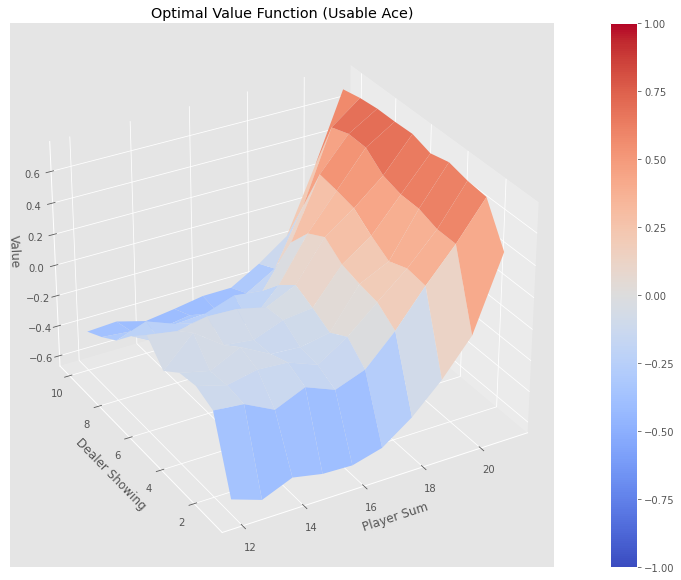

In [45]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")